# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [221]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [222]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034L,)
test label shape: (677L,)
dev label shape: (676L,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [223]:
def P1(num_examples=5):
    
### STUDENT START ###
    for i in range(5):
        print("TEXT {}:\n{}\n\nLABEL {}: {}\n".format(i, train_data[i], i, newsgroups_train.target_names[train_labels[i]]))
    
### STUDENT END ###
P1()

TEXT 0:
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

LABEL 0: comp.graphics

TEXT 1:


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

LABEL 1: talk.relig

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [224]:
def P2():
### STUDENT START ###
    vectorizer = CountVectorizer()
    vectors = vectorizer.fit_transform(train_data)
    
    # Number of samples by number of features
    print("Vectorizer shape: {}".format(vectors.shape))
    #Size of the vocabulary is the number of unique words stored in columns
    print("Vocabulary size: {}".format(vectors.shape[1]))
    vocab_train = vectorizer.vocabulary_
    #print("Vocabulary size: {}".format(len(vocab_train))) 
    # Count of the non-zero features in the whole matrix
    print("Count of the non-zero features in the whole matrix: {}".format(vectors.nnz))
    # Average non-zero features per example
    print("Average non-zero features per example: {}".format(vectors.nnz / float(vectors.shape[0])))
    # Non-zero features by total features (fraction of non-zero features in the matrix)
    matrix_size = float(vectors.shape[0]) * float(vectors.shape[1])
    print("Fraction of non-zero features in the matrix: {}".format(vectors.nnz / matrix_size))
    
    # Mapping from integer feature name to original token string
    feature_names = np.asarray(vectorizer.get_feature_names())
    sorted_feature_names = sorted(feature_names)
    print("First and last feature strings: {} {}".format(sorted_feature_names[0],sorted_feature_names[-1]))
    
    # Specify a vocabulary of four words
    vectorizer_vocab = CountVectorizer(vocabulary=['atheism', 'graphics', 'space', 'religion'])
    vectors_vocab = vectorizer_vocab.fit_transform(train_data)
    # Number of samples by number of features
    print("Vectorizer shape: {}".format(vectors_vocab.shape))
    # Average non-zero features per example
    print("Average non-zero features per example: {}".format(vectors_vocab.nnz / float(vectors_vocab.shape[0])))
    
    # Extract bigram character features
    # Using char_wb which is considered more accurate for languages that use whitespace word separators
    vectorizer_bigram = CountVectorizer(ngram_range=(2, 2))
    #vectorizer_bigram = CountVectorizer(analyzer='char_wb', ngram_range=(2, 2))
    vectors_bigram = vectorizer_bigram.fit_transform(train_data)
    #vectors_bigram_vocab = vectorizer_bigram.vocabulary_
    #print len(vectors_bigram_vocab)
    print("Bigram vocabulary size: {}".format(vectors_bigram.shape[1]))

    # Extract trigram character features
    #trigram_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(3, 3))
    trigram_vectorizer = CountVectorizer(ngram_range=(3, 3))
    vectors_trigram = trigram_vectorizer.fit_transform(train_data)
    print("Trigram vocabulary size: {}".format(vectors_trigram.shape[1]))
    
    # Prune words that appear in fewer than 10 documents
    vectorizer_min10 = CountVectorizer(min_df=10)
    vectors_min10 = vectorizer_min10.fit_transform(train_data)  
    print("Vocabulary size for words with document frequency at least 10: {}".format(vectors_min10.shape[1]))
    
    # Find what fraction of the words in the dev data are missing from the train vocabulary
    vectorizer_dev = CountVectorizer()
    vectors_dev = vectorizer_dev.fit_transform(dev_data)
    vocab_dev = vectorizer_dev.vocabulary_
    vocab_diff = set(vocab_dev.keys()) - set(vocab_train.keys())
    #print("Train vocab size: {}  Dev vocab size: {}".format(len(vocab_train), len(vocab_dev)))
    #print("Count of words in the dev data missing from the train vocab: {}".format(len(vocab_diff)))
    print("Fraction of words in the dev data missing from the vocab: {}".format(float(len(vocab_diff)) / float(len(vocab_dev))))
    
### STUDENT END ###
P2()

Vectorizer shape: (2034, 26879)
Vocabulary size: 26879
Count of the non-zero features in the whole matrix: 196700
Average non-zero features per example: 96.7059980334
Fraction of non-zero features in the matrix: 0.00359782722696
First and last feature strings: 00 zyxel
Vectorizer shape: (2034, 4)
Average non-zero features per example: 0.268436578171
Bigram vocabulary size: 194891
Trigram vocabulary size: 315692
Vocabulary size for words with document frequency at least 10: 3064
Fraction of words in the dev data missing from the vocab: 0.247876400345


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

Best k nearest neighbors score: 0.4395 
Best k nearest neighbors param: 
{'n_neighbors': 8}
Best Multinomial Naive Bayes score: 0.8387 
Best Multinomial Naive Bayes param: 
{'alpha': 0.01}
Best Logistic Regression score: 0.7842 
Best Logistic Regression param: 
{'C': 0.1}
0.001  :  [ 0.16509345  0.20095275  0.18067094  0.18724278]
0.01  :  [ 2.54152207  2.93970937  2.86246914  2.25002868]
0.1  :  [ 27.12951991  24.66047449  27.45877978  23.02193717]
1  :  [ 167.0079219   130.95419334  157.96598986  145.73967307]
10  :  [ 586.63160065  448.55352334  539.27066106  530.544321  ]
100  :  [ 1400.44920557  1091.64353145  1305.62509951  1311.9419164 ]
1000  :  [ 2693.43205037  1926.16980194  2413.47885308  2572.45499027]


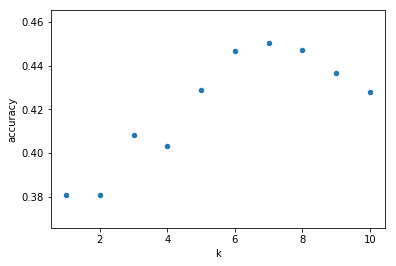

In [225]:
def P3():
### STUDENT START ###
    # Use default CountVectorizer options
    vectorizer = CountVectorizer()
    # Fit the transformer to the training set and create feature vectors
    vectors_train = vectorizer.fit_transform(train_data)
    # Create feature vectors for the dev data
    vectors_dev = vectorizer.transform(dev_data)
    
    # Fit KNN classifier and find the optimal value for k
    k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    accuracy = []
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)    
        knn.fit(vectors_train, train_labels)
        pred = knn.predict(vectors_dev)
        # Calculate the f1 (metrics.f1_score) score
        score = metrics.f1_score(dev_labels, pred, average='weighted')
        accuracy.append(score)

    # Plot graph to visualize the best value of k
    pd.DataFrame({'k': k_values, 'accuracy': accuracy}).plot(kind='scatter', x='k', y='accuracy')
    
    # Find the optimal value for k using grid search
    n_neighbors = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
    knn = KNeighborsClassifier()
    k_searcher = GridSearchCV(knn, n_neighbors, cv=10)
    k_searcher.fit(vectors_train, train_labels)
    print("Best k nearest neighbors score: {:.4} \nBest k nearest neighbors param: ".format(k_searcher.best_score_))
    print k_searcher.best_params_
    
    # Fit Multinomial Naive Bayes model and find the optimal value for alpha
    alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
    mnb = MultinomialNB()   
    alpha_searcher = GridSearchCV(mnb, alphas, cv=10)
    alpha_searcher.fit(vectors_train, train_labels)
    print("Best Multinomial Naive Bayes score: {:.4} \nBest Multinomial Naive Bayes param: ".format(alpha_searcher.best_score_))
    print alpha_searcher.best_params_

        
    # Fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization
    C = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    logit = LogisticRegression(penalty='l2')
    C_searcher = GridSearchCV(logit, C, cv=10)
    C_searcher.fit(vectors_train, train_labels)
    print("Best Logistic Regression score: {:.4} \nBest Logistic Regression param: ".format(C_searcher.best_score_))
    print C_searcher.best_params_
    
    # Output the sum of the squared weight values for each class for each setting of the C parameter. 
    c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    for c in c_values:
        logit = LogisticRegression(penalty='l2', C=c)
        logit.fit(vectors_train, train_labels)
        calc = np.sum([x*x for x in logit.coef_], axis=1)
        print c, ' : ', calc
### STUDENT END ###
P3()

ANSWER: 
(a)Nearest neighbors does not work well for sparse data with a large number of features. It is better suited to denser data with 5 or less features, and in this case the training set vocabulary is 26879.
(b) The logistic regression model may be overfitting the data leading to complex decision boundaries and poor ability to generalize for accurate prediction. Regularizaton is supposed to help alleviate this problem. There may be some rare vocabulary values in the data which do not provide enough variation for logistic regression to work well. Logistic regression might work better if the size of the training set were increased. Naive Bayes works better with a small training set.  
(c) C is the inverse of regularization strength. Smaller values of C specify stronger regularization. Regularization addresses overfitting by penalizing additional complexity in the model. The sum of the squared coefficients becomes smaller as more penalty is applied for model complexity.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [226]:
def P4():
### STUDENT START ###
    # Train a logistic regression model
    vectorizer = CountVectorizer()
    vectors_train = vectorizer.fit_transform(train_data)
    logit = LogisticRegression()
    #logit = LogisticRegression(penalty='l2', C=0.1)
    logit.fit(vectors_train, train_labels)

    # Find the 5 features with the largest weights for each label -- 20 features in total.
    weights = logit.coef_
    nrows = weights.shape[0]
    ind = np.empty([nrows, 5], dtype=int)
    for row in range(nrows):
        ind[row] = np.argpartition(weights[row,:], -5)[-5:]
        #ind[row] = np.argpartition(np.abs(weights[row,:]), -5)[-5:]
    features = np.sort(ind.flatten())
    
    # Get feature names for table labels
    names = vectorizer.get_feature_names()
       
    # Create a table with 20 rows and 4 columns that shows the weight for each of these features 
    # for each of the labels
    print("Features with largest weights unigram:\n")
    print("{:20s} | {:>15s} | {:>15s} | {:>15s} | {:>20s}".format('Features',newsgroups_train.target_names[0],newsgroups_train.target_names[1],newsgroups_train.target_names[2],newsgroups_train.target_names[3]))
    for f in features:
        print("{:20s} | {:15.3f} | {:15.3f} | {:15.3f} | {:20.3f}".format(names[f],weights[0, f],weights[1, f],weights[2, f],weights[3, f]))

    # Extract bigram character features
    vectorizer_bigram = CountVectorizer(ngram_range=(2, 2))
    #vectorizer_bigram = CountVectorizer(analyzer='char_wb', ngram_range=(2, 2))
    vectors_bigram_train = vectorizer_bigram.fit_transform(train_data)
    #logit_bigram = LogisticRegression(penalty='l2', C=0.1)
    logit_bigram = LogisticRegression()
    logit_bigram.fit(vectors_bigram_train, train_labels)

    # Find the 5 features with the largest weights for each label -- 20 features in total.
    weights_bigram = logit_bigram.coef_
    nrows_bigram = weights_bigram.shape[0]
    ind_bigram = np.empty([nrows, 5], dtype=int)
    for row in range(nrows_bigram):
        ind_bigram[row] = np.argpartition(weights_bigram[row,:], -5)[-5:]
        #ind_bigram[row] = np.argpartition(np.abs(weights_bigram[row,:]), -5)[-5:]
    features_bigram = np.sort(ind_bigram.flatten())
    
    names_bigram = vectorizer_bigram.get_feature_names()

        
    # Create a table with 20 rows and 4 columns that shows the weight for each of these features 
    # for each of the labels
    print("\nFeatures with largest weights bigram:\n")
    print("{:20s} | {:>15s} | {:>15s} | {:>15s} | {:>20s}".format('Features',newsgroups_train.target_names[0],newsgroups_train.target_names[1],newsgroups_train.target_names[2],newsgroups_train.target_names[3]))
    for f in features_bigram:
        print("{:20s} | {:15.3f} | {:15.3f} | {:15.3f} | {:20.3f}".format(names_bigram[f],weights_bigram[0, f],weights_bigram[1, f],weights_bigram[2, f],weights_bigram[3, f]))


### STUDENT END ###
P4()

Features with largest weights unigram:

Features             |     alt.atheism |   comp.graphics |       sci.space |   talk.religion.misc
3d                   |          -0.359 |           1.125 |          -0.702 |               -0.379
atheism              |           0.939 |          -0.411 |          -0.449 |               -0.435
atheists             |           1.029 |          -0.097 |          -0.320 |               -0.835
blood                |          -0.533 |          -0.107 |          -0.316 |                1.055
bobby                |           0.990 |          -0.221 |          -0.341 |               -0.463
christian            |          -0.608 |          -0.418 |          -0.271 |                1.117
christians           |          -0.740 |          -0.410 |          -0.525 |                1.148
computer             |           0.143 |           0.978 |          -0.682 |               -0.487
deletion             |           1.126 |          -0.398 |          -0.420 |  

ANSWER: Many of the bigrams include common words such as 'the', 'is', 'in' which are not very useful for text analysis. There are even some bigrams which just contain common words such as 'was just' and 'you are'.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [227]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
### STUDENT START ###
    # Lowercase everything
    s1 = s.lower()
    
    # Replace sequences of numbers with a single token
    s2 = re.sub(r'\d+', ' number ', s1)
    
    # Remove non-letter characters
    s3 = re.sub('[\W]+', ' ', s2)
    
    # Shorten long words
    # Replace sses with ss
    s4 = re.sub(r'sses\b', 'ss', s3)
    # Remove trailing s from words ending in s but not ss
    #s5 = re.sub(r'(\w{3,})s\b(?<!s)', r'\1', s4)
    s5 = re.sub(r's\b(?<!s)', r'\1', s4)
    # Remove common suffixes
    s6 = re.sub(r'tional\b', 'tion', s5)
    s7 = re.sub(r'(izer|ization)\b', 'ize', s6)
    s8 = re.sub(r'(ational|ation|ator)\b', 'ate', s7)
    # Stopwords (copied from nltk)
    s9 = re.sub(r'\ball\b|\bjust\b|\bbeing\b|\bover\b|\bboth\b|\bthrough\b|\byourselves\b|\bits\b|\bbefore\b|\bherself\b|\bhad\b|\bshould\b|\bto\b|\bonly\b|\bunder\b|\bours\b|\bhas\b|\bdo\b|\bthem\b|\bhis\b|\bvery\b|\bthey\b|\bnot\b|\bduring\b|\bnow\b|\bhim\b|\bnor\b|\bdid\b|\bthis\b|\bshe\b|\beach\b|\bfurther\b|\bwhere\b|\bfew\b|\bbecause\b|\bdoing\b|\bsome\b|\bare\b|\bour\b|\bourselves\b|\bout\b|\bwhat\b|\bfor\b|\bwhile\b|\bdoes\b|\babove\b|\bbetween\b|\bbe\b|\bwe\b|\bwho\b|\bwere\b|\bhere\b|\bhers\b|\bby\b|\bon\b|\babout\b|\bof\b|\bagainst\b|\bor\b|\bown\b|\binto\b|\byourself\b|\bdown\b|\byour\b|\bfrom\b|\bher\b|\btheir\b|\bthere\b|\bbeen\b|\bwhom\b|\btoo\b|\bthemselves\b|\bwas\b|\buntil\b|\bmore\b|\bhimself\b|\bthat\b|\bbut\b|\bdon\b|\bwith\b|\bthan\b|\bthose\b|\bhe\b|\bme\b|\bmyself\b|\bthese\b|\bup\b|\bwill\b|\bbelow\b|\bcan\b|\btheirs\b|\bmy\b|\band\b|\bthen\b|\bis\b|\bam\b|\bit\b|\ban\b|\bas\b|\bitself\b|\bat\b|\bhave\b|\bin\b|\bany\b|\bif\b|\bagain\b|\bno\b|\bwhen\b|\bsame\b|\bhow\b|\bother\b|\bwhich\b|\byou\b|\bafter\b|\bmost\b|\bsuch\b|\bwhy\b|\ba\b|\boff\b|\bi\b|\byours\b|\bso\b|\bthe\b|\bhaving\b|\bonce\b', '', s8)
    
   # Remove ing or ed <- this created too many incomplete words
    #s998 = re.sub(r'(\w{3,})(ing|ed)\b', r'\1', s5)
    #s999 = re.sub(r'(at|bl|iz)\b', r'\1e', s6)
    
    #print s9
    return s9
### STUDENT END ###

def P5():
### STUDENT START ###
    # Using the empty preprocessor
    vectorizer_e = CountVectorizer(preprocessor=empty_preprocessor)
    vectors_e_train = vectorizer_e.fit_transform(train_data)
    vectors_e_dev = vectorizer_e.transform(dev_data)
    logit_e = LogisticRegression(penalty='l2', C=0.1)
    logit_e.fit(vectors_e_train, train_labels)
    pred_e = logit_e.predict(vectors_e_dev)
    #print("Stopwords empty preprocessor: {}".format(vectorizer_e.stop_words_)) 

    # Vocabulary size    
    #print("Vocabulary size with empty preprocessor: {}".format(vectors_e_train.shape[1]))
    vocab_e = vectorizer_e.vocabulary_
    print("Vocabulary size with empty preprocessor: {}".format(len(vocab_e))) 
        
    # Calculate the f1 (metrics.f1_score) score
    score_e = metrics.f1_score(dev_labels, pred_e, average='weighted')
    print("Score with empty preprocessor: {}".format(score_e))

    # Using the better preprocessor
    vectorizer_p = CountVectorizer(preprocessor=better_preprocessor)
    vectors_p_train = vectorizer_p.fit_transform(train_data)
    vectors_p_dev = vectorizer_p.transform(dev_data)
    logit_p = LogisticRegression(penalty='l2', C=0.1)
    logit_p.fit(vectors_p_train, train_labels)
    pred_p = logit_p.predict(vectors_p_dev)
        
    # Vocabulary size    
    #print("Vocabulary size with better preprocessor: {}".format(vectors_p_train.shape[1]))
    vocab_p = vectorizer_p.vocabulary_
    print("Vocabulary size with better preprocessor: {}".format(len(vocab_p))) 

    # Calculate the f1 (metrics.f1_score) score
    score_p = metrics.f1_score(dev_labels, pred_p, average='weighted')
    print("Score with better preprocessor: {}".format(score_p))

### STUDENT END ###
P5()

Vocabulary size with empty preprocessor: 33291
Score with empty preprocessor: 0.701397454667
Vocabulary size with better preprocessor: 24111
Score with better preprocessor: 0.710646679637


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

Number of non-zero learned weights using L1: 358
Number of non-zero learned weights using L2: 107516
Accuracy: 0.678238912987
C value: 0.001 	 Size of vocabulary: 3 	 Accuracy: 0.352602587841
C value: 0.01 	 Size of vocabulary: 17 	 Accuracy: 0.461277684198
C value: 0.1 	 Size of vocabulary: 211 	 Accuracy: 0.671357160572
C value: 1 	 Size of vocabulary: 1040 	 Accuracy: 0.661253371708
C value: 10 	 Size of vocabulary: 2896 	 Accuracy: 0.679255345895


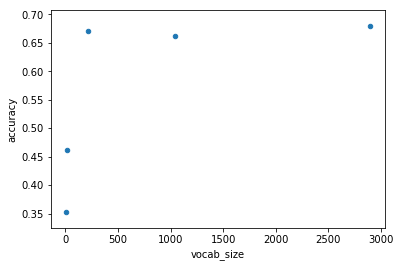

In [228]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    # Train a logistic regression model
    vectorizer = CountVectorizer()
    vectors_train = vectorizer.fit_transform(train_data)
    vectors_dev = vectorizer.transform(dev_data)

    # Using the L1 penalty
    logit_l1 = LogisticRegression(penalty='l1', C=0.1)
    logit_l1.fit(vectors_train, train_labels)
    
    # Output the number of learned weights that are not equal to zero
    #print logit_l1.coef_.shape
    print ("Number of non-zero learned weights using L1: {}".format(np.count_nonzero(logit_l1.coef_)))
    
    # Using the L2 penalty
    logit_l2 = LogisticRegression(penalty='l2', C=0.1)
    logit_l2.fit(vectors_train, train_labels)

    # Output the number of learned weights that are not equal to zero
    #print logit_l2.coef_.shape
    print ("Number of non-zero learned weights using L2: {}".format(np.count_nonzero(logit_l2.coef_)))
    
    # Reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight
    # Sum the absolute weights for each feature to get index of features with at least one non-zero weight
    # Create a vocabulary from those features using the feature names
    weights_l1 = logit_l1.coef_
    idx, = np.where(np.sum(np.absolute(weights_l1), axis=0) != 0)
    names = vectorizer.get_feature_names()
    vocab_l1 = np.asarray(names)[idx]
    
    # Retrain a model using "l2"
    vectorizer_vocab = CountVectorizer(vocabulary=vocab_l1)
    vectors_train_vocab = vectorizer_vocab.fit_transform(train_data)
    vectors_dev_vocab = vectorizer_vocab.transform(dev_data)
    logit_l2_vocab = LogisticRegression(penalty='l2', C=0.1)
    logit_l2_vocab.fit(vectors_train_vocab, train_labels)
    
    # Accuracy
    pred = logit_l2_vocab.predict(vectors_dev_vocab)
    score = metrics.f1_score(dev_labels, pred, average='weighted')
    print("Accuracy: {}".format(score))
    
    # Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get 
    # when pruning unused features by adjusting the C parameter.
    accuracy = []
    vocab_size = []
    c_values = [0.001, 0.01, 0.1, 1, 10]
    for c in c_values:
        # Fit train data to default count vectorizer
        vectorizer = CountVectorizer()
        vectors_train = vectorizer.fit_transform(train_data)
        # Logistic Regression with L1 penalty to obtain vocab from non zero weights
        logit_l1 = LogisticRegression(penalty='l1', C=c, tol=.01)
        logit_l1.fit(vectors_train, train_labels)
        weights_l1 = logit_l1.coef_
        idx, = np.where(np.sum(np.absolute(weights_l1), axis=0) != 0)
        vocab_l1 = np.asarray(names)[idx]
        # Size of the vocabulary
        size_vocab_l1 = len(vocab_l1)
        vocab_size.append(size_vocab_l1)
        # Fit train data to count vectorizer using the generated vocabulary
        vectorizer_vocab = CountVectorizer(vocabulary=vocab_l1)
        vectors_train_vocab = vectorizer_vocab.fit_transform(train_data)
        vectors_dev_vocab = vectorizer_vocab.transform(dev_data)
        # Logistic Regression with L2 penalty to obtain score
        logit_l2_vocab = LogisticRegression(penalty='l2', C=c, tol=.01)
        logit_l2_vocab.fit(vectors_train_vocab, train_labels)
        pred = logit_l2_vocab.predict(vectors_dev_vocab)
        score = metrics.f1_score(dev_labels, pred, average='weighted')
        accuracy.append(score)
        print("C value: {} \t Size of vocabulary: {} \t Accuracy: {}".format(c,len(vocab_l1),score))

        
    # Plot score against size_vocab_l1        
    pd.DataFrame({'vocab_size': vocab_size, 'accuracy': accuracy}).plot(kind='scatter', x='vocab_size', y='accuracy')
    
    ### STUDENT END ###
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [231]:
def P7():
### STUDENT START ###

    # Use the TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer()
    vectors_train_tfidf = tfidf_vectorizer.fit_transform(train_data)
    vectors_dev_tfidf = tfidf_vectorizer.transform(dev_data)
    
    # Train a logistic regression model with C=100.
    logit = LogisticRegression(C=100)
    logit.fit(vectors_train_tfidf, train_labels)
    
    # Make predictions on the dev data and retrieve probability estimates
    pred_prob = logit.predict_proba(vectors_dev_tfidf)
    
    # Columns are classes and rows are documents
    #print pred_prob[0:5,:]
    
    # Index of maximum predicted probability for each sample
    ind_max_pred = pred_prob[:,:].argmax(axis=1)
    # maximum predicted probability / predicted probability of the correct label
    R = pred_prob[np.arange(len(pred_prob)),ind_max_pred] / pred_prob[np.arange(len(pred_prob)),dev_labels]

    # Largest values of R
    R_max = np.argpartition(R, -3)[-3:]
    #print R[R_max]
    
    # Corresponding documents
    for i in R_max:
        print("Document {} with R value {} correct label {} highest prob label {}:\n{}\n\n".format(i, R[i], newsgroups_train.target_names[dev_labels[i]], newsgroups_train.target_names[ind_max_pred[i]], dev_data[i]))
    
    
## STUDENT END ###
P7()

Document 607 with R value 287.307166293 correct label alt.atheism highest prob label talk.religion.misc:

The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...



Document 665 with R value 325.003977561 correct label talk.religion.misc highest prob label comp.graphics:
Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.


Document 215 with R value 929.357446388 correct label talk.religion.misc highest prob label comp.graphics:
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. T

ANSWER: CountVectorizer counts the tokens. TfidfVectorizer scales down the impact of tokens that occur very frequently in the data by multiplying the token frequency by the inverse document frequency (number of documents containing the token). This allows more focus on interesting features that occur less frequently in the data.

The model is having difficulty distinguishing between talk.religion.misc and alt.atheism which is not surprising as there are probably many similar features in those two classes. It is also incorrectly classifying samples into comp.graphics. This might be caused by the use of technology related terms such as 'ftp', 'printers' and 'internet'. Adding some of those common terms to a stopword list might improve accuracy.


(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

In [234]:
def P8():
    # Train a bigram logistic regression model using the stop words and lowercase in CountVectorizer
    vectorizer = CountVectorizer(ngram_range=(2, 2),stop_words='english',lowercase=True)
    vectors_train = vectorizer.fit_transform(train_data)
    vectors_dev = vectorizer.transform(dev_data)
    
    logit = LogisticRegression(penalty='l2', C=0.1)
    logit.fit(vectors_train, train_labels)

    pred = logit.predict(vectors_dev)
    score = metrics.f1_score(dev_labels, pred, average='weighted')
    print score
P8()

0.495092809534
